# 3D Pose Generation

With `NextFace`, we can generate a face with various poses from a single image. This is useful when we want to expand our database, in cases where we only have a single image/subject.

For more details, check out their [repository](https://github.com/abdallahdib/NextFace)!

> Disclaimer: This is simply a tutorial on how to use `NextFace`. I do not claim to own any of the code or trained models in `./models/`, I simply modified their code to fit my needs and this repository, and some I updated so it can run with up-to-date libraries. All credit goes to the original repository, so please cite and give them a star!

For this notebook, you need a different working environment from the previous notebooks. For the installation guide, please refer [here](https://github.com/abdallahdib/NextFace/blob/main/INSTALL).

Or, in your Anaconda Prompt, run these commands

    conda create --name faceNext python=3.8.0
    conda activate faceNext
    pip install redner-gpu
    pip install --upgrade pip setuptools wheel --user
    pip install opencv-python==4.5.5.64
    pip install mediapipe
    conda install -c 1adrianb face_alignment=1.2.0
    conda install -c anaconda h5py
    pip install ipykernel

Finally, install the [pytorch](https://pytorch.org/) version that's compatible with your OS and devices. 

> Disclaimer: if possible, please follow the instructions on the original repository, but they don't work for me, and this is what ends up working for me.

In [45]:
from models.NextFace.optimizer import Optimizer
from models.NextFace.config import Config
from models.NextFace.utils import *
from models.NextFace.image import saveImage
import math
import json
import mediapipe
import numpy as np

For this example, we will try to convert `./dataset/train/joy/img_2.jpg`. Let's set the input and output paths

In [46]:
input_path = './dataset/train/joy/img_2.jpg'
output_path = './output/3D_pose_generation/'

## Part 1: Optimize

Remember to configure your device in `./models/NextFace/optimConfig.ini`. If you're using GPU, please change the device to `'cuda'`. For better results, make sure that `MediaPipe` is installed correctly.

In [47]:
config_path = './models/NextFace/optimConfig.ini'
config = Config()
config.fillFromDicFile(config_path)

if config.device == 'cuda' and torch.cuda.is_available() == False:
    print('[WARN] no cuda enabled device found. switching to cpu... ')
    config.device = 'cpu'
if config.lamdmarksDetectorType == 'mediapipe':
    try:
        from models.NextFace.landmarksmediapipe import LandmarksDetectorMediapipe
    except:
        print('[WARN] Mediapipe for landmarks detection not availble. falling back to FAN landmarks detector. You may want to try Mediapipe because it is much accurate than FAN (pip install mediapipe)')
        config.lamdmarksDetectorType = 'fan'

loading optim config from:  ./models/NextFace/optimConfig.ini


In [48]:
sharedIdentity = None
checkpoint = ''
doStep1 = True
doStep2 = True
doStep3 = True

Loading Basel Face Model 2017 from ./models/NextFace/baselMorphableModel/morphableModel-2017.pickle...
loading mesh normals...
loading uv parametrization...
loading landmarks association file...
creating sampler...
loading image from path: 

init camera pose...
1/3 => Optimizing head pose and expressions using landmarks...


 ./dataset/train/joy/img_2.jpg
[INFO] resizing input image to fit: 256 px resolution...
detecting landmarks using: mediapipe


100%|██████████| 2000/2000 [00:07<00:00, 277.69it/s]
2/3 => Optimizing shape, statistical albedos, expression, head pose and scene light...
100%|██████████| 401/401 [01:47<00:00,  3.74it/s]
3/3 => finetuning albedos, shape, expression, head pose and scene light...
100%|██████████| 101/101 [00:27<00:00,  3.62it/s]
took 2.38 minutes to optimize
saving to: ' ./output/3D_pose_generation/joy// '. hold on... 


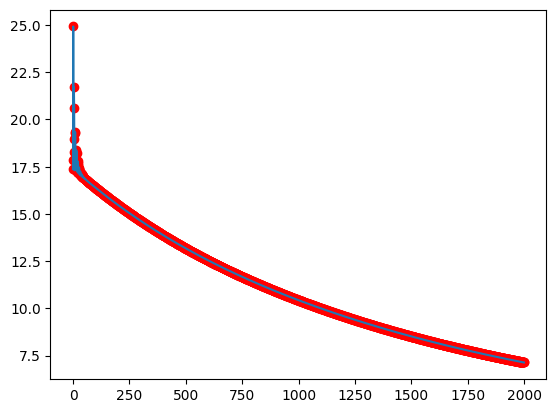

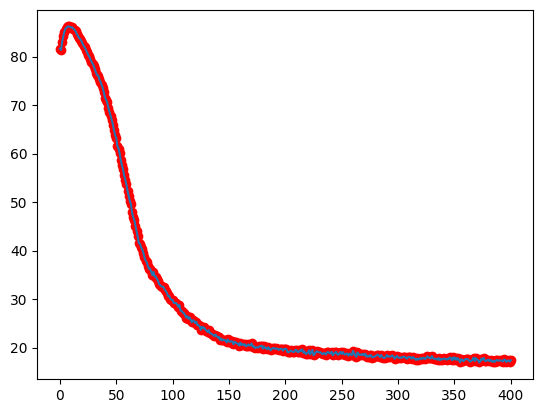

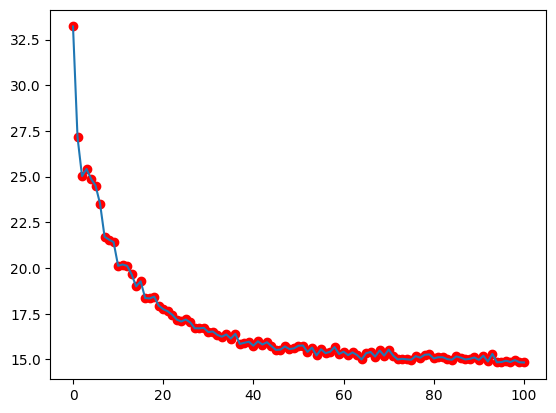

In [49]:
optimizer = Optimizer(outputDir=output_path, config=config)
optimizer.run(
    input_path, 
    sharedIdentity= sharedIdentity,
    checkpoint= checkpoint,
    doStep1= doStep1,
    doStep2 = doStep2,
    doStep3= doStep3
)

If you encountered an error in the middle of running, you can restart from the last checkpoint, simply set the checkpoint path to one of the pickle files in `{OUPUT_DIR}/checkpoints`, and change the steps you don't want to repeat to `False`.

## Part 2: Generate

This is the part where we'll generate the face with multiple angles, using the output from the first part. The function below will is a producer function that simply saves your image. This code is used to rotaet on vertical axis, you need to have ffmpeg installed to produce the final gif image or video.

In [50]:
output_path_full = output_path + 'render/'

In [51]:
frameIndex = 0
def produce(optimizer):
    global frameIndex
    images = optimizer.pipeline.render(
        None, 
        optimizer.vEnhancedDiffuse, 
        optimizer.vEnhancedSpecular,
        optimizer.vEnhancedRoughness,
    )

    for i in range(images.shape[0]):
        fileName = output_path_full + '/frame_'+ str(i) + '_%04d.png' % frameIndex
        saveImage(images[i], fileName)
    
    frameIndex += 1


In [52]:
DTR = math.pi / 180.0
minBound = -30.0 * DTR  # -65
maxBound = 30.0 * DTR  # 65
step = 2.85 * DTR  # 0.75

initAngle = optimizer.pipeline.vRotation[..., 1].clone()
currentAngle = initAngle.clone()

This will take a while to run! Don't worry. You can check the progress in your output directory.

In [53]:
parameters = './output/3D_pose_generation/joy/checkpoints/stage3_output.pickle'

optimizer = Optimizer(output_path, config, mkdir=False)
optimizer.pipeline.renderer.samples = config.rtSamples
optimizer.loadParameters(parameters)

if True:
        frameIndex = 0
        print('animating reconstruction, this may take some time depending on the number of raytracing samples and ur gpu. please wait...')
        while currentAngle > minBound:
            currentAngle -= step
            optimizer.pipeline.vRotation[..., 1] = currentAngle
            produce(optimizer)

        while currentAngle < maxBound:
            currentAngle += step
            optimizer.pipeline.vRotation[..., 1] = currentAngle
            produce(optimizer)

        while currentAngle > initAngle:
            currentAngle -= step
            optimizer.pipeline.vRotation[..., 1] = currentAngle
            produce(optimizer)

        optimizer.pipeline.vRotation[..., 1] = initAngle
        produce(optimizer)
        
import os

cmd = "ffmpeg -f image2 -framerate 20 -y -i " + output_path_full + "frame_0_%04d.png " + output_path_full + "/optimized.gif"
os.system(cmd)

Loading Basel Face Model 2017 from ./models/NextFace/baselMorphableModel/morphableModel-2017.pickle...
loading mesh normals...
loading uv parametrization...
loading landmarks association file...
creating sampler...
animating reconstruction, this may take some time depending on the number of raytracing samples and ur gpu. please wait...


0

If you want more angles of rotation, here is my code for it! You can change the range and intervals to fit your needs, and it will save the pictures to the output directory.

In [ ]:
x_axis = np.arange(2.9, 3.7, 0.15, dtype=float) # range 2.9~3.7, intervals of 0.15
y_axis = np.arange(-75, 76, 25, dtype=int) # range -75~75, intervals of 25
for x in x_axis:
    for y in y_axis:
        optimizer.pipeline.vRotation[..., 0] = x
        optimizer.pipeline.vRotation[..., 1] = y
        produce(optimizer)

## Conclusion

In this notebook I showed how to generate different image angles from a single picture, which I used as training data for a domain adversarial network (DAN) in my project. In my case, I only have one image/subject, which is why I have to think of different ways to improve the prediction accuracy, and this is one of them! However, it is still better to have multiple pictures of the subject, so I hope you don't have to be in this situation 😭